In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.fft import fft

plt.style.use('dark_background')

In [ ]:
# https://www.youtube.com/watch?v=spUNpyF58BY&t=35s

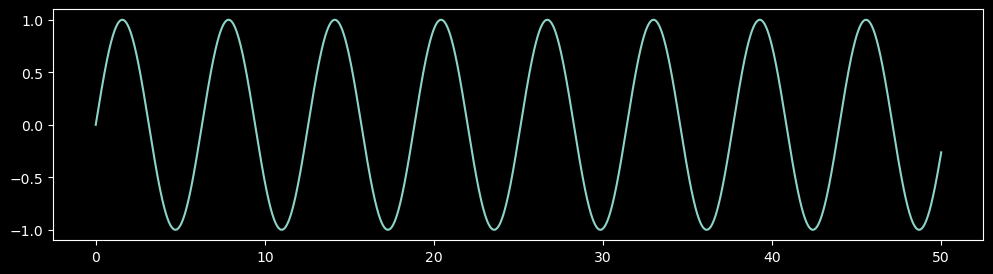

In [9]:
t = np.linspace(0,50,5000)
x = np.sin(t)
plt.figure(figsize=(12,3))
plt.plot(t,x)
plt.show()

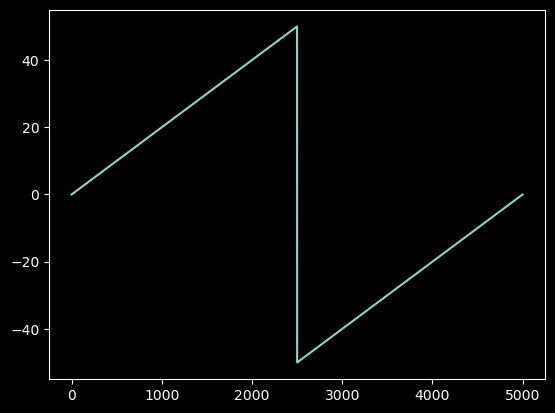

In [15]:
spectrum = fft(x)
sampling_rate = 100
frequencies = np.fft.fftfreq(len(x), d=1/sampling_rate)

plt.plot(frequencies)

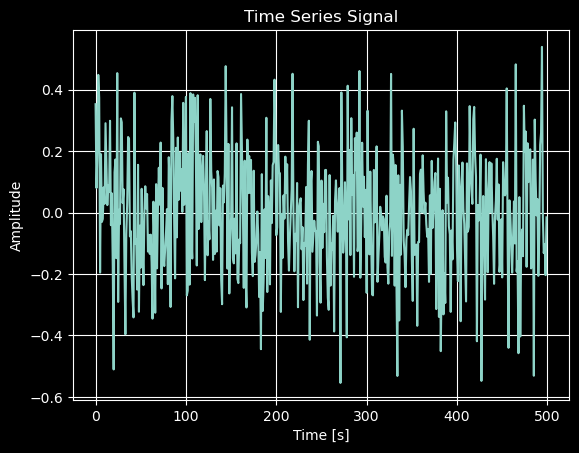

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Generate a synthetic time series: combination of sinusoids + noise
np.random.seed(0)
T = 1.0     # Sample spacing (1 second)
N = 500     # Number of samples
t = np.linspace(0.0, N*T, N, endpoint=False)

# Simulated time series: 2Hz + 5Hz components + noise
y = 0.7 * np.sin(2.0*np.pi*2.0*t) + 0.3 * np.sin(2.0*np.pi*5.0*t) + 0.2*np.random.randn(N)

plt.plot(t, y)
plt.title("Time Series Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


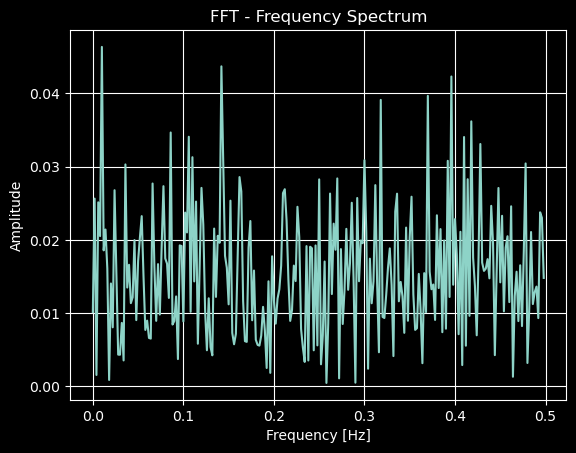

In [18]:
# Perform FFT
yf = fft(y)
xf = fftfreq(N, T)[:N//2]  # Only take the positive frequencies
amplitudes = 2.0/N * np.abs(yf[0:N//2])  # Normalize

plt.plot(xf, amplitudes)
plt.title("FFT - Frequency Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [19]:
# Feature 1: Dominant frequency
dominant_freq = xf[np.argmax(amplitudes)]
print("Dominant Frequency: {:.2f} Hz".format(dominant_freq))

# Feature 2: Spectral Centroid (weighted mean frequency)
spectral_centroid = np.sum(xf * amplitudes) / np.sum(amplitudes)
print("Spectral Centroid: {:.2f} Hz".format(spectral_centroid))

# Feature 3: Spectral Bandwidth (spread around centroid)
spectral_bandwidth = np.sqrt(np.sum(((xf - spectral_centroid) ** 2) * amplitudes) / np.sum(amplitudes))
print("Spectral Bandwidth: {:.2f} Hz".format(spectral_bandwidth))

# Feature 4: Total Spectral Energy
spectral_energy = np.sum(amplitudes ** 2)
print("Spectral Energy: {:.2f}".format(spectral_energy))


Dominant Frequency: 0.01 Hz
Spectral Centroid: 0.25 Hz
Spectral Bandwidth: 0.15 Hz
Spectral Energy: 0.08
